In [1]:
import plotly.graph_objects as go
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.metrics.pairwise import rbf_kernel
import csv

In [2]:
n = 100
d1 = 28
d2 = 28
L = 100
step = 10
seed = 4
pins_random = False
sigma = 10
np.random.seed(seed)

In [3]:
if pins_random:
    data_folder = f"./data/Synthetic_{n}images_{d1}by{d2}pixels_upto{L}pins_{seed}seed/"
else:
    data_folder = f"./data/Synthetic_{n}images_{d1}by{d2}pixels_{step}_distanced_grid_pins_{seed}seed/"

# delete the data folder if it already exists
if os.path.exists(data_folder) and os.path.isdir(data_folder):
    shutil.rmtree(data_folder)
    
# create a new data folder
os.makedirs(f"{data_folder}images")

In [4]:
!nvidia-smi

Mon Nov 27 00:19:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB            Off| 00000000:86:00.0 Off |                    0 |
| N/A   36C    P0               55W / 300W|      0MiB / 32768MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# mean and covariance functions
a = 3
b = 0.5 # smaller b - small bias

# nonlinear mean (quadratic)
def quad_mean(p_1, p_2, z):
    return a * z[(p_1, p_2)] ** 2 + b

# linear mean
def mean(p_1, p_2, z):
    return a * z[(p_1, p_2)] + b

# RBF kernel with a small width
gamma = (1 / (sigma ** 2))
def cov(p_1, p_2, gamma):
    """
        K(p_1, p_2) = exp(-gamma ||p_1-p_2||^2)
    """
    return rbf_kernel(p_1, p_2, gamma=gamma) # this should only depend on p1 and p2 - enforce continuity

In [6]:
def show_pins(image, pins, outputs):
    """Show image with pins"""
    plt.imshow(image, extent=[0,d1,0,d2])
    plt.scatter(pins[:, 0], pins[:, 1], s=10, marker='.', c='r')

In [7]:
header = ['image', 'pins', 'outputs']
with open(f"{data_folder}/pins.csv", 'w') as file:
    writer = csv.writer(file)
    writer.writerow(header)

In [8]:
def reformat(arr):
    return [(i[0][0], i[1][0]) for i in arr]

NameError: name 'min_eig' is not defined

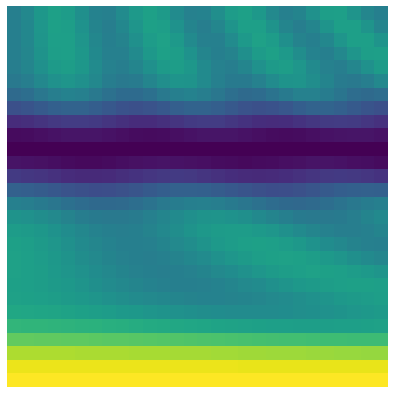

In [9]:
for i in range(n):
    #these will generate the images
    c = np.random.randint(0, 10, size=4)
    func_list = [np.sin, np.cos]
    funcs = np.random.choice(func_list, 3)
    p1 = np.linspace(0, 5, d1)
    p2 = np.linspace(0, 5, d2)
    P1, P2 = np.meshgrid(p1, p2, indexing='ij')
    
    def f(P1, P2):
        return c[0] * funcs[0](P1) ** c[1] + c[2] * funcs[1](c[3] + P2 * P1) * funcs[2](P1)
    
    z = f(P1, P2)
    
    # indexing check
    # for i, vali in enumerate(p1):
    #     for j, valj in enumerate(p2):
    #         if z[i, j] != f(vali, valj):
    #             print("not equal!")
    
    fig = plt.figure(figsize=(7,7))
    plt.imshow(z, origin='lower')  # http://brantr.github.io/blog/matplotlib-imshow-orientation/
    plt.axis('off')
    
    img_name = f"{i}.png"    
    fig.savefig(f'{data_folder}/images/{img_name}', bbox_inches='tight', pad_inches=0)
    
    if pins_random:
        # choose how many pins to sample
        L_i = np.random.randint(1, L)

        # coordinates of the random pins
        p_1i = np.random.randint(d1, size=(L_i, 1))
        p_2i = np.random.randint(d2, size=(L_i, 1))
        # p_i = np.concatenate((p_1i, p_2i), axis=1) # coordinates of the pins
        p_i = list(zip(p_1i.reshape(L_i).tolist(), p_2i.reshape(L_i).tolist())) # coordinates of the pins
    else:
        # coordinates of the mesh pins
        p_1i = np.arange(0, d1, step).reshape(-1, 1)
        p_2i = np.arange(0, d2, step).reshape(-1, 1)
        p_i = [(x.tolist(), y.tolist()) for x in p_1i for y in p_2i] # coordinates of the pins
    
    mean_vec = mean(np.asarray(p_i)[:, 1], np.asarray(p_i)[:, 0], z)
    
    cov_mat = cov(np.asarray(p_i)[:, 1], np.asarray(p_i)[:, 0], gamma)
    # Ensure positive-semidefinite covariance matrix
    def ensure_positive_semidefinite(mat, threshold=1e-5):
        min_eig = np.min(np.real(np.linalg.eigvals(mat)))
        if min_eig < threshold:
            mat -= (min_eig - threshold) * np.eye(*mat.shape)
        return mat

    # Adjust the covariance matrix
    cov_mat = ensure_positive_semidefinite(cov_mat, threshold=1e-5)
    
    # this should correct the potential negative eigenvalues due to floating errors
    # min_eig = np.min(np.real(np.linalg.eigvals(cov_mat)))
    if min_eig < 0:
        # cov_mat -= 100*min_eig * np.eye(*cov_mat.shape)
        print("min eig < 0")
    # Calculate eigenvalues
    eigenvalues = np.linalg.eigvals(cov_mat)
    
    print("Eigenvalues:", eigenvalues)
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html
    # .reshape(-1) converts a 2D matrix to a 1D vector (e.g. 100x1 --> 1x100)
    y_i = np.random.default_rng().multivariate_normal(mean_vec.reshape(-1), cov_mat)  
    
    # describe the dataset somewhere (latex)
    plt.scatter(np.asarray(p_i)[:, 0], np.asarray(p_i)[:, 1], s=10, marker='.', c='r')
    p_i = reformat(p_i)
    for i in range(len(p_i)):
        plt.annotate(f'{y_i[i]:.2f}', p_i[i])
    # print(np.shape(y_i))

    with open(f"{data_folder}/pins.csv", 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([img_name, p_i, y_i.tolist()])

In [ ]:
fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(z, origin='lower')
plt.colorbar()
fig.canvas.draw()

# grab the pixel buffer and dump it into a numpy array
X = np.array(fig.canvas.renderer.buffer_rgba())
print(z.shape, X.shape)
# saving an image using the imsave function
plt.imsave('sample.png', X)

In [ ]:
from scipy.stats import multivariate_normal

p_1 = np.array(range(0, d1))
p_2 = np.array(range(0, d2))
print(np.shape(z))
full_mean = mean(p_1, p_2, z)
print(np.shape(full_mean))
full_cov = cov(p_1.reshape(-1, 1), p_2.reshape(-1, 1), gamma)
print(np.shape(full_cov))

y = multivariate_normal(full_mean, full_cov, allow_singular=True)
print(y.pdf(z))

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(P1, P2, z, 50)
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('z')
ax.set_title('3D contour')
plt.show()

In [ ]:
layout = go.Layout(width=500, height=500)

fig = go.Figure(go.Histogram2d(
        x=p1,
        y=p2,
        texttemplate= "%{z}",
    ), layout=layout) #, layout_xaxis_range=[-5, 5], layout_yaxis_range=[-5, 5])
fig.show()